In [15]:
# The SUODI Principle

# Environment Setup
import os
import sys
from pathlib import Path
import shutil 

import numpy as np 
import pandas as pd
from pyod.models.ecod import ECOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import matplotlib.pyplot as plt
import seaborn as sns


# Configuration 
DATA_PATH = "../../datasets/Classical/11_donors.npz"

### Installing SUOD Module

You can install the `suod` module directly from a notebook cell using the following script:

```python
import sys

!{sys.executable} -m pip install -U suod
```

In [2]:
donors = np.load(DATA_PATH, allow_pickle=True)
donors

NpzFile '../../datasets/Classical/11_donors.npz' with keys: X, y

In [3]:
X, y = donors['X'], donors['y']

In [4]:
print(X.shape)

(619326, 10)


In [5]:
print(X)

[[0.       1.       1.       ... 0.       0.       0.003289]
 [1.       1.       0.       ... 0.5      0.02649  0.029605]
 [0.       1.       1.       ... 0.       0.       0.003289]
 ...
 [0.23748  0.       0.278581 ... 0.529271 0.005148 0.014346]
 [0.23748  0.       0.278581 ... 0.529271 0.005148 0.014346]
 [0.       0.       0.       ... 1.       0.       0.003289]]


In [6]:
print(y.shape); print(y)

(619326,)
[0 0 0 ... 0 0 0]


In [8]:
print(y[:500])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 

In [9]:
np.count_nonzero(y)

36710

In [10]:
np.count_nonzero(y) / len(y)

0.05927411411760527

In [11]:
len(y) - np.count_nonzero(y)

582616

In [17]:
if __name__ == "__main__":
    contamination = 0.1                        # percentage of outliers

    # train ECOD detector
    clf_name = 'ECOD'
    clf = ECOD()

    # you could try parallel version as well.
    # clf = ECOD(n_jobs=2)
    clf.fit(X)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_                                           # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_                                # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y, y_test_scores)


On Training Data:
ECOD ROC:0.8885, precision @ rank n:0.2867

On Test Data:
ECOD ROC:0.8885, precision @ rank n:0.2867


RandomForestRegressor()



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished




On Training Data:
SUOD ROC:1.0, precision @ rank n:1.0

On Test Data:
SUOD ROC:1.0, precision @ rank n:1.0


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


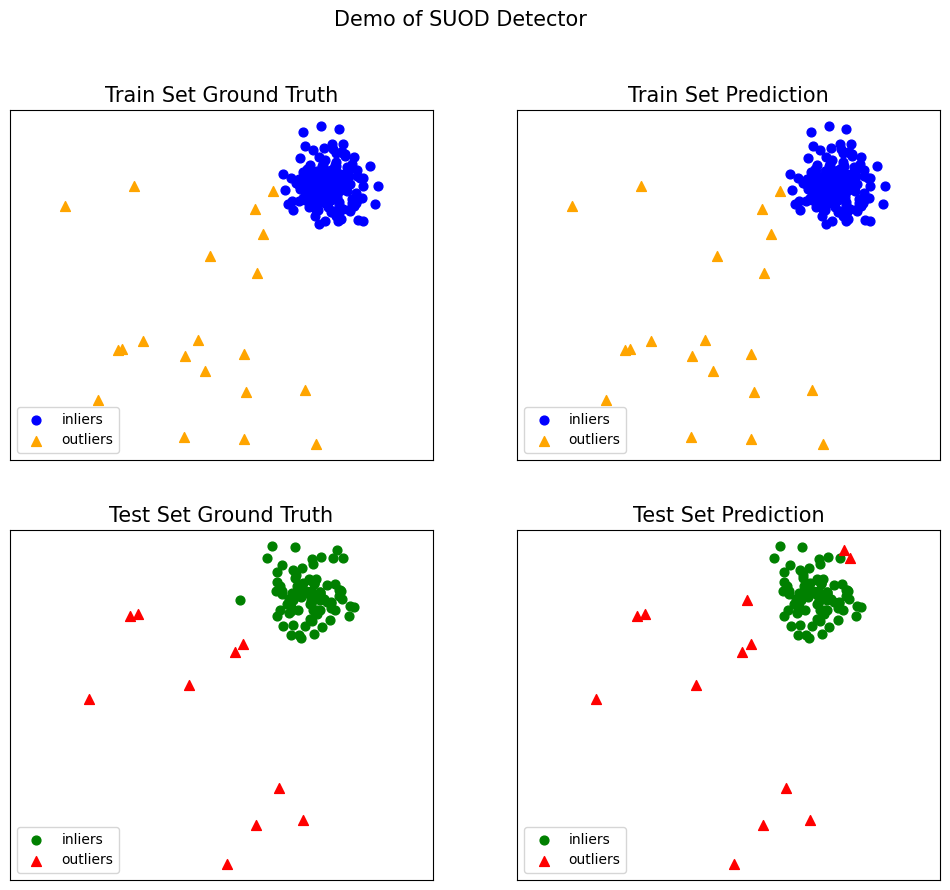

In [33]:
# -*- coding: utf-8 -*-
"""Example of using SUOD for accelerating outlier detection
"""


from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
# sys.path.append(
#     os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1                   # percentage of outliers
    n_train = 200                         # number of training points
    n_test = 100                          # number of testing points

    # Generate sample data
    X_train, X_test, y_train, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train SUOD
    clf_name = 'SUOD'

    # initialized a group of outlier detectors for acceleration
    detector_list = [
                     LOF(n_neighbors=15),
                     LOF(n_neighbors=20),
                     LOF(n_neighbors=25),
                     LOF(n_neighbors=35),
                     COPOD(),
                     IForest(n_estimators=100),
                     IForest(n_estimators=200)
                    ]

    # decide the number of parallel process, and the combination method
    clf = SUOD(base_estimators = detector_list,
               n_jobs=4,
               combination='average',
               verbose=False)

    # or to use the default detectors
    # clf = SUOD(n_jobs=2, combination='average',
    #            verbose=False)
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_                  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_       # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)                 # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)     # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)

In [28]:
# y_train_scores

In [34]:
# evaluate_print